# Basic MCMC

## Monte Carlo Walker

Making the plot of markov chain walker, explaination

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from jax import random, grad
import jax.numpy as jnp

sns.set_style('whitegrid')


1.0


Text(0.5, 0.92, 'Wireframe')

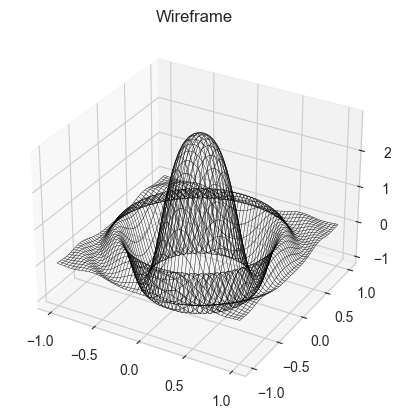

In [2]:
# Making a monte carlo optimiser for a function

def complexf1(x,y):
    return ((x*jnp.sin(5*y)+y*jnp.sin(5*x))**2)*(jnp.cosh(jnp.sin(10*x)*x)) + ((x*jnp.cos(5*y)-y*jnp.sin(5*x))**2)*(jnp.cosh(jnp.cos(20*y)*y))
def complexf2(x,y):
    return ((x*jnp.sin(20*y)+y*jnp.sin(20*x))**2)*(jnp.cosh(jnp.sin(10*x)*x)) + ((x*jnp.cos(10*y)-y*jnp.sin(10*x))**2)*(jnp.cosh(jnp.cos(20*y)*y))
def simplef1(x,y):
    return 3*jnp.cos(((3*x)**2+(3*y)**2))*jnp.exp(-3*(x**2+y**2))
def simplef2(x,y):
    return 3*jnp.cos(((3*x)**2+(3*y)**2))*jnp.exp(-0.1*(x+y)) + ((x*jnp.sin(5*y)+y*jnp.sin(5*x))**2)*(jnp.cosh(jnp.sin(10*x)*x))

print(jnp.cos(0.0))

x = jnp.linspace(-1,1,200)
y = jnp.linspace(-1,1,200)
X,Y = jnp.meshgrid(x,y)
Z = simplef1(X,Y)

fig = plt.figure()
ax = plt.axes(projection = '3d')
ax.plot_wireframe(X,Y,Z,color = 'black', lw = 0.3)
ax.set_title('Wireframe')

Text(0.5, 0.92, 'Monte Carlo Walk')

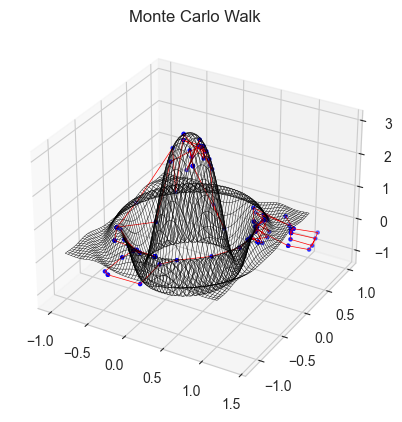

In [3]:
# Doing monte carlo optimisation on this function:-
x0 = 0.8; y0 = 0.8
n = 200

def monte_carlo_walk(fun, x0, y0, n, bounds = (np.array([-2,2]) ,np.array([-2,2])) ):
    xs = np.zeros(n); ys = np.zeros(n)
    for i in range(n):
        x1 = 0.2*random.normal(random.PRNGKey(i),shape = (1,)) + x0
        y1 = 0.2*random.normal(random.PRNGKey(i+1),shape = (1,)) + y0
        if (x1 < bounds[0][0]) or (x1 > bounds[0][1]) or (y1 < bounds[1][0]) or (y1 > bounds[1][1]):
            x1 = x0
            y1 = y0
            i = i-1
            continue
        if fun(x1,y1) > fun(x0,y0):
            x0 = x1
            y0 = y1
        else:
            flip = random.uniform(random.PRNGKey(i+2),shape = (1,))
            if flip < fun(x1,y1)/fun(x0,y0):
                x0 = x1
                y0 = y1
            else:
                x0 = x0
                y0 = y0
        xs[i] = x0; ys[i] = y0
    return xs, ys

fig = plt.figure()
xs, ys = monte_carlo_walk(simplef1, x0, y0, n)
ax = plt.axes(projection = '3d')
ax.plot_wireframe(X,Y,Z,color = 'black', lw = 0.3)
ax.scatter(xs,ys,simplef1(xs,ys),color = 'blue',s = 5)
ax.plot(xs,ys,simplef1(xs,ys),color = 'red',lw = 0.5)
ax.set_title('Monte Carlo Walk')

# Try to add slider, which actually works on jupyter book

Note on why gradient descent fails here,
Then take 10000 points and show that almost same histogram has been made

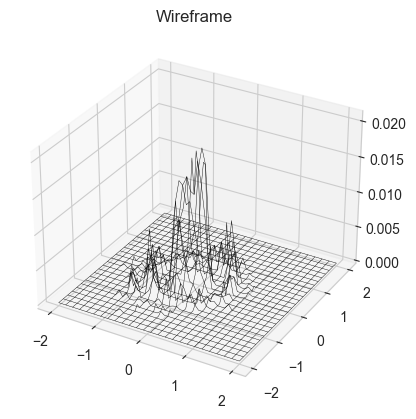

In [4]:
xs, ys = monte_carlo_walk(simplef1, x0, y0, 10000)

def plot3dhist(xs, ys, starts, ends, bins):
    z_hist = np.zeros((bins[0]+1, bins[1]+1))
    for i in range(len(xs)):
        z_hist[int((xs[i]-starts[0])/(ends[0]-starts[0])*bins[0])-1, int((ys[i]-starts[1])/(ends[1]-starts[1])*bins[1])-1] += 1

    x = jnp.linspace(starts[0],ends[0], bins[0]+1)
    y = jnp.linspace(starts[1],ends[1], bins[1]+1)
    X,Y = jnp.meshgrid(x,y)
    Z = z_hist/len(xs)
    fig = plt.figure()
    ax = plt.axes(projection = '3d')
    ax.plot_wireframe(X,Y,Z,color = 'black', lw = 0.3)
    ax.set_title('Wireframe')
    plt.show()

# plot3dhist(xs[5000:9999],ys[5000:9999],[-2,-2],[2,2],(50,50))
plot3dhist(xs,ys,[-2,-2],[2,2],(50,50))

This took almost 20 s to run on my computer, for such a simple implementation (although it uses a lot of for loop). This makes us appreciate how much powerful our methods have to be if we have to work on complex distributions with thousands of parameters and many complicated priors.

Make a good function named danger function which we can use in other demonstrations also

In [110]:
# Let us do this using gradient descent
def simplef12(w):
    x = w[0]; y = w[1]
    return 3*jnp.cos(((3*x)**2+(3*y)**2))*jnp.exp(-3*(x**2+y**2))

gradient = grad(simplef12)(jnp.array([0.8,0.8]))
print(gradient)

[0.6487649 0.6487649]


## Basics of markov chains

The above monte carlo walker seems to be efficiently travelling along the target function in proportion to the function values. If we have a probability distribution that we have to sample then, this seems like a good method as it only requires that we can get the value at any point on the function. But why does it work?

The reason being that the methods forms a set of stochastic variables known as a Markov chain, whose stationary distribution is equal to the target distribution.


A Markov chain or Markov process is a stochastic model describing a sequence of possible events in which the probability of each event depends only on the state attained in the previous event. 

$ P(X_{t+1} = X^{t+1} | X_{t} = X^{t}, X_{t-1} = X^{t-1}, X_{t-2} = X^{t-2}, ... ) = P(X_{t+1} = X^{t+1} | X_{t} = X^{t})  $,

here $X_{t}$, is the t'th element of the chain of random variables

<img src="/Users/gaurav/Desktop/Open_Source/Jupyter_Books/CompStats/img/Simulation/Graphical_Rep.png"  width="300" height="300">

To simplify, let us take an example of a chain with discrete, finite range. 
Suppose a person takes a random walk on a number line on the values 1, 2, 3, 4, 5. If the person is currently at an interior value (2, 3, 4), in the next second she is equally likely to remain at that number or move to an adjacent number. If she does move, she is equally likely to move left or right. If the person is currently at one of the end values (1 or 5), in the next second she is equally likely to stay still or move to the adjacent location.


This is a simple discrete Markov chain, as the probability of the girl going to any place in next step depends on only her current position. (Discrete as the chain is discrete random variables, not because of the range space). We can describe her movements in terms of transition probabilities in a matrix P where

$ P_{i,j} = prob$(transitioning from state $X_{i}$ to $X_{j}$)

<img src="/Users/gaurav/Desktop/Open_Source/Jupyter_Books/CompStats/img/Simulation/Transition_Matrix.png"  width="300" height="200">

Credits: http://markov.yoriz.co.uk/


### Some Important Features
1. Irreducible Markov Chain: A markov chain in which each point is reachable from any other point in finite number of steps

2. Periodic Markov Chain: A chain which can return to the same state only in regular intervals of time. (Chain length)

3. Reccurent Markov Chain: A chain is said to be recurrent if, any time that we leave any state, we will return to that state in the future with probability one. On the other hand, if the probability of returning is less than one, the state is called transient.

We represent one’s current location as a probability row vector of the form: $p = (p_{1}, p_{2}, p_{3}, p_{4}, p_{5})$
where $p_{i}$ represents the probability that the person is currently in state i .

If $p^{j}$ represents the location of the traveler at step j, then the location of the traveler at the  j+1 step is given by the matrix product: $p^{j+1} = p^{j} P$, and hense the probability vector after travelling m steps will be:

$p^{j+1} = p^{j} P^{m}$

**STATIONARITY**

For an irreducible, aperiodic Markov chain, there is a limiting behavior of the matrix power $P^{m}$ as m approaches infinity. Specifically, this limit is equal to

$W = \lim_{m \to \infty} P^{m}$

The implication of this result is that, as one takes an infinite number of moves, the probability of landing at a particular state does not depend on the initial starting state.

From this result about the limiting behavior of the matrix power $P^{m}$, one can derive a rule for determining this constant vector. Suppose we can find a probability vector w such that $w = wP$. This vector w is said to be the **stationary distribution**. If a Markov chain is irreducible and aperiodic, then it has a unique stationary distribution. Moreover, as illustrated above, the limiting distribution of this Markov chain, as the number of steps approaches infinity, will be equal to this stationary distribution.

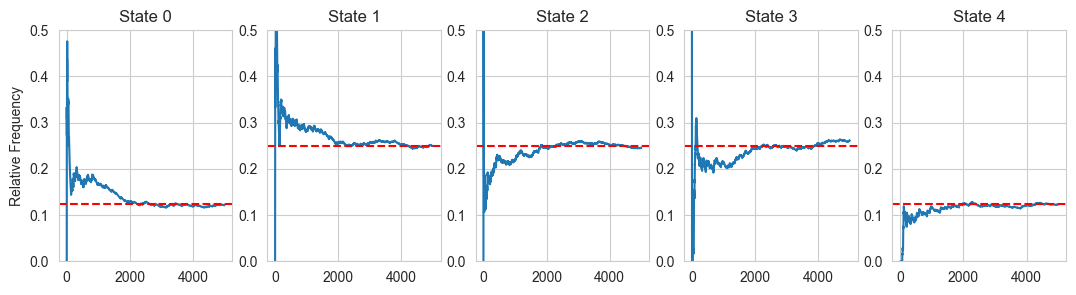

In [42]:
# Simulating relative frequencies of a markov chain random walker
from numpy import random as npr
npr.seed(16)

steps = 5000
probs = np.zeros((5,steps))
P = np.array([[0.5,0.5,0.0,0.0,0.0],[0.25,0.5,0.25,0.0,0.0],[0.0,0.25,0.5,0.25,0.0],
              [0.0,0.0,0.25,0.5,0.25],[0.0,0.0,0.0,0.5,0.5]])

pstart = np.array([0.0,0.0,0.0,1.0,0.0])
state = 3
probs[:,0] = pstart

for i in range(steps-1):
    u = npr.uniform(0,1)
    if state == 0:
        if u < 0.5: state = 0
        else: state = 1
    elif state == 1:
        if u < 0.25: state = 0
        elif u < 0.75: state = 1
        else: state = 2
    elif state == 2:
        if u < 0.25: state = 1
        elif u < 0.75: state = 2
        else: state = 3
    elif state == 3:
        if u < 0.25: state = 2
        elif u < 0.75: state = 3
        else: state = 4
    else:
        if u < 0.5: state = 3
        else: state = 4
    probs[state,i+1] = 1
    probs[:,i+1] = (probs[:,i])*(i/(i+1)) + (1/(i+1))*probs[:,i+1]

fig, ax = plt.subplots(1, 5, figsize =(13, 3))
x = np.linspace(1,steps,steps)
for i in range(5):
    ax[i].plot(x,probs[i,:])
    ax[i].set_title('State '+str(i))
    ax[i].set_ylim([0.0,0.5])
    if (i == 0) | (i == 4):
        ax[i].axhline(y = 0.125, color = 'red', linestyle = '--')
    else:
        ax[i].axhline(y = 0.25, color = 'red', linestyle = '--')
    if (i == 0):
        ax[i].set_ylabel('Relative Frequency')


[0.12320892 0.24746703 0.25       0.25253297 0.12679108]


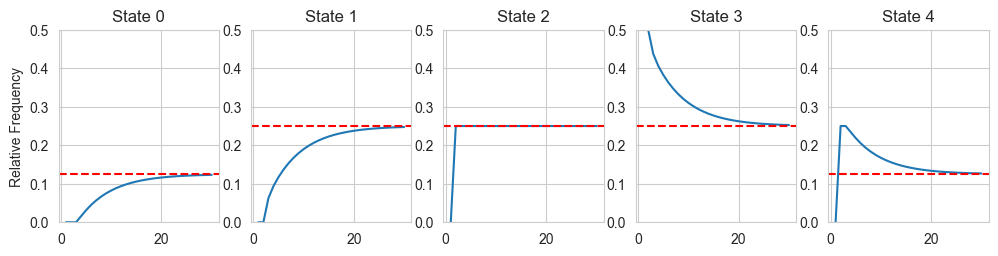

In [43]:
# Lets run a code and see what the stationary distribution looks after many turns:
# We will start at position 4, and then let the chain run for 5000 steps

steps = 30
probs = np.zeros((5,steps))
P = np.array([[0.5,0.5,0.0,0.0,0.0],[0.25,0.5,0.25,0.0,0.0],[0.0,0.25,0.5,0.25,0.0],
              [0.0,0.0,0.25,0.5,0.25],[0.0,0.0,0.0,0.5,0.5]])

pstart = np.array([0.0,0.0,0.0,1.0,0.0])
probs[:,0] = pstart

for i in range(steps-1):
    probs[:,i+1] = probs[:,i]@P

fig, ax = plt.subplots(1, 5, figsize =(12, 2.5))
x = np.linspace(1,steps,steps)
for i in range(5):
    ax[i].plot(x,probs[i,:])
    ax[i].set_title('State '+str(i))
    ax[i].set_ylim([0.0,0.5])
    if (i == 0) | (i == 4):
        ax[i].axhline(y = 0.125, color = 'red', linestyle = '--')
    else:
        ax[i].axhline(y = 0.25, color = 'red', linestyle = '--')
    if (i == 0):
        ax[i].set_ylabel('Relative Frequency')
print(probs[:,steps-1])

## Metropolis Algorithm